In [124]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn.functional as F
from torch import Tensor
from datetime import datetime
import math
import random
from mynn import *
import numpy as NP
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
initLogging("Common init")

dtype = torch.float
log("dtype", dtype)

dvc = torch.device("cpu")
log("device", dvc.type)

contextSize = 3
log("contextSize", contextSize)


Common init:         -------------------------- 2023-07-06 16:20:29
dtype:               torch.float32
device:              cpu
contextSize:         3


In [126]:
logSection("Prepare dataset")

filePath = "names.txt"
log("filePath", filePath)

trRatio = 0.8
log("trRatio", trRatio)

devRatio = 0.9
log("devRatio", devRatio)

wordShufflingSeed = 42
log("wordShufflingSeed", wordShufflingSeed)

words = readFileSplitByLine(filePath)
random.seed(wordShufflingSeed)
random.shuffle(words)
log("first few words", words[:5])

lenWords = len(words);
log("lenWords", lenWords)

allPossibleChars = sorted(list(set("".join(words))))
log("allPossibleChars", allPossibleChars)

stoi = sToI(allPossibleChars)
log("stoi", stoi)

itos = iToS(stoi)
log("itos", itos)

vocabularyLength = len(itos)
log("vocabularyLength", vocabularyLength)

lenTrain = int(trRatio * lenWords)
trWords = words[:lenTrain]
trX, trY = buildDataSet(trWords, contextSize, stoi, itos, dvc)
log("data set training", lenTrain, trX.shape, trY.shape, trWords[:3])

endDev = int(devRatio * lenWords)
devWords = words[lenTrain:endDev];
devX, devY = buildDataSet(devWords, contextSize, stoi, itos, dvc)
log("data set dev", endDev - lenTrain, devX.shape, devY.shape, devWords[:3])

lenTest = lenWords - endDev
tstWords = words[endDev:]
tstX, tstY = buildDataSet(tstWords, contextSize, stoi, itos, dvc)
log("data set test", lenTest, tstX.shape, tstY.shape, tstWords[:3])

Prepare dataset:     -------------------------- 2023-07-06 16:20:30
filePath:            names.txt
trRatio:             0.8
devRatio:            0.9
wordShufflingSeed:   42
first few words:     ['yuheng', 'diondre', 'xavien', 'jori', 'juanluis']
lenWords:            32033
allPossibleChars:    ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:                {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos:                {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocabularyLength:    27
data set training:   25626 torch.Size([18

In [127]:
logSection("Build network")

embeddingDims = 10
log("embeddingDims", embeddingDims)

hiddenLayerSize = 200
log("hiddenLayerSize", hiddenLayerSize)

np = makeNetwork(g, vocabularyLength, embeddingDims, contextSize, hiddenLayerSize, dvc)
log("parametersCount", sum(p.nelement() for p in np.all))

log("random probability", f"{-torch.tensor(1 / vocabularyLength).log().item():.4f}")

@torch.no_grad()
def trLoss(): return getLoss(np, np.C[trX], trY)

@torch.no_grad()
def devLoss(): return getLoss(np, np.C[devX], devY)

@torch.no_grad()
def tstLoss(): return getLoss(np, np.C[tstX], tstY)

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.dev = devLoss()
    l.tst = tstLoss()
    return l

def logLosses():
    losses = getLosses()
    l1 = f"{losses.tr.loss.item():>10.4f}"
    l2 = f"{losses.dev.loss.item():>10.4f}"
    l3 = f"{losses.tst.loss.item():>10.4f}"
    logSimple(f"{l1} {l2} {l3}")

Build network:       -------------------------- 2023-07-06 16:20:30
embeddingDims:       10
hiddenLayerSize:     200
W1ratio:             0.3042903097250923
b1ratio:             0.001
W2ratio:             0.01
b2ratio:             0
parametersCount:     11897
random probability:  3.2958


Learning:            -------------------------- 2023-07-06 16:20:30
trainingBatchSize:   32
trainingSteps: :     5708
maxIteration:        200000
repeats:             36
maxLr:               0.14
minLr:               0.0001
learningSeed:        2147483647
actualIterations:    200000
  0,      0 losses:     0.0000       3.3045     3.3038     3.3041
  1,   5708 losses:     2.1007       2.2974     2.3104     2.3174
  2,  11416 losses:     1.9635       2.2544     2.2754     2.2717
  3,  17124 losses:     2.1763       2.2195     2.2388     2.2445
  4,  22832 losses:     2.0465       2.2016     2.2320     2.2323
  5,  28540 losses:     2.2577       2.1936     2.2235     2.2260
  6,  34248 losses:     1.8039       2.1730     2.2072     2.2094
  7,  39956 losses:     1.9433       2.1767     2.2141     2.2105
  8,  45664 losses:     2.1812       2.1477     2.1884     2.1864
  9,  51372 losses:     2.5244       2.1543     2.1954     2.1978
 10,  57080 losses:     2.3615       2.1651     2.2124  

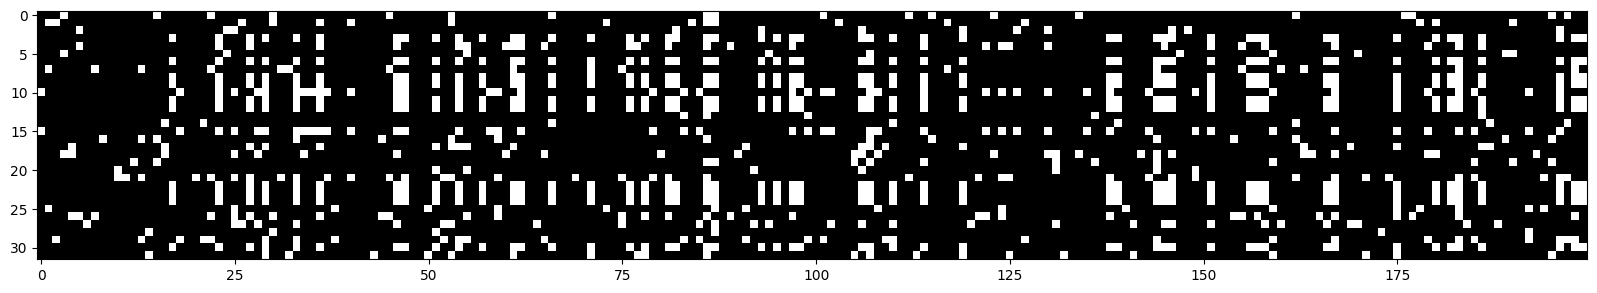

In [128]:
logSection("Learning")

trainingBatchSize = 32
log("trainingBatchSize", trainingBatchSize)

trXLength = trX.shape[0]
trainingSteps = (trXLength // trainingBatchSize) + 1
log ("trainingSteps: ", trainingSteps)

maxIteration = 200_000
log("maxIteration",maxIteration)

repeats = 36
log("repeats",repeats)

maxLr = 0.14
log("maxLr", maxLr)

minLr = 0.0001
log("minLr", minLr)

learningSeed = 2147483647
log("learningSeed", learningSeed)
g = torch.Generator(device=dvc).manual_seed(learningSeed)

actualIterations = min(maxIteration, repeats * math.ceil(trXLength / trainingBatchSize))
log("actualIterations", actualIterations)

lr = 0.1;
lre = torch.linspace(-3, 0, trainingSteps)
lrs = 10 ** lre
lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
fr = ForwardPassResult()
fr.loss = torch.tensor(0)
up = UpdateNetResult()

i = 0
for repeat in range(repeats):
    
    if i >= maxIteration:
        break;

    logSimple(f"{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ", end="")
    logLosses()

    for start in range(0, trXLength, trainingBatchSize):

        if i >= maxIteration:
            log("break")
            break;
        
        end = min(start + trainingBatchSize, trXLength)
        #miniBatchIxs = torch.arange(start, end)
        miniBatchIxs = torch.randint(0, trXLength, (trainingBatchSize,), generator=g, device=dvc)
        fr = forwardPass(np, trX, trY, miniBatchIxs)
        
        backwardPass(np.all, fr.loss)

        if i == 1:
            plt.figure(figsize=(20,10))
            plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")
        
        up = updateNet(np.all, i, actualIterations, maxLr, minLr)
        lrAtIx.append(up.learningRate)

        stepIx.append(i)
        lossAtIx.append(fr.loss.item())
        logLossAtIx.append(fr.loss.log10().item())

        #lr = lrs[i].item()
        #lrAtIx.append(lrs[i].item())
        
        i += 1

logLosses()

#bestLr = lrs[findLowestIndex(lossAtIx)].item();
#log("best learning rate", bestLr)
log("emb.shape", fr.emb.shape)
log("h.shape", fr.h.shape)
log("logits.shape", fr.logits.shape)

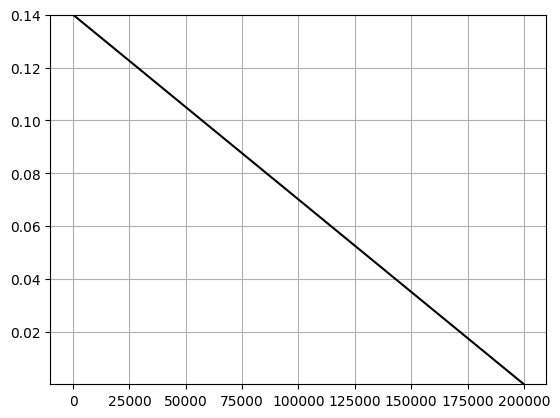

Actual min max LR 0.14 0.0001006994999999955


In [129]:
plt.plot(range(len(lrAtIx)), lrAtIx, "black")
plt.ylim(min(lrAtIx), max(lrAtIx))
plt.grid(True)
plt.show()
print("Actual min max LR", max(lrAtIx), min(lrAtIx))

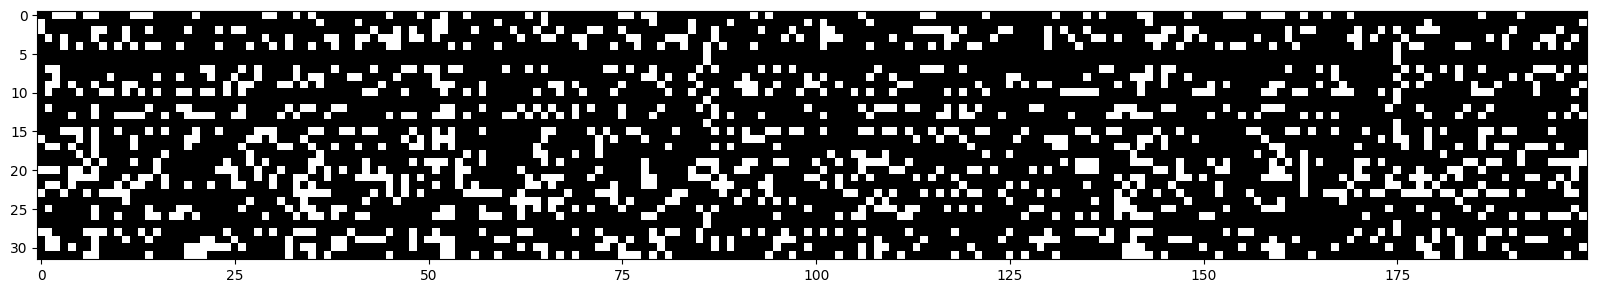

In [130]:
plt.figure(figsize=(20,10))
plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")

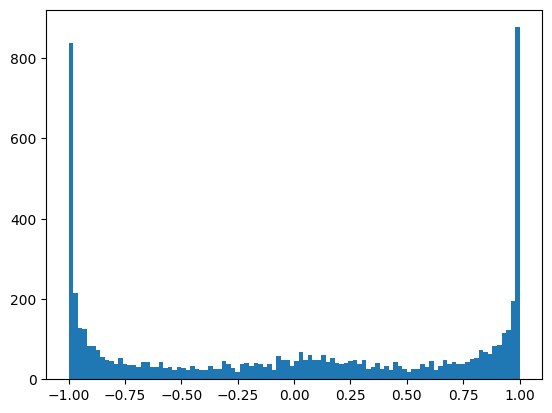

In [131]:
plt.hist(fr.h.view(-1).tolist(), 100);

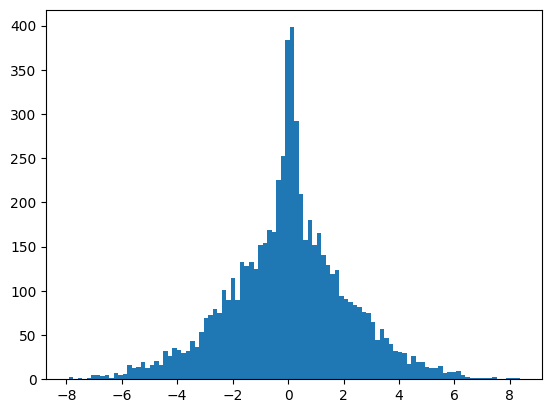

In [132]:
plt.hist(fr.hPreActivations.view(-1).tolist(), 100);

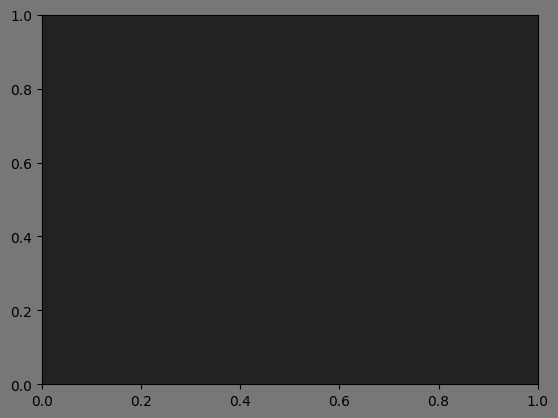

In [133]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
#ax.plot(lrAtIx, lossAtIx)
plt.show()

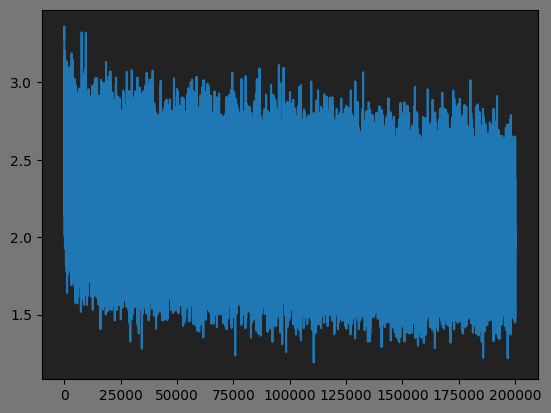

In [134]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
ax.plot(stepIx, lossAtIx)
plt.show()

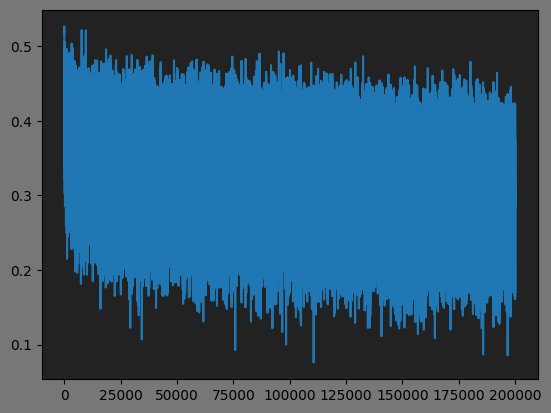

In [135]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
ax.plot(stepIx, logLossAtIx)
plt.show()

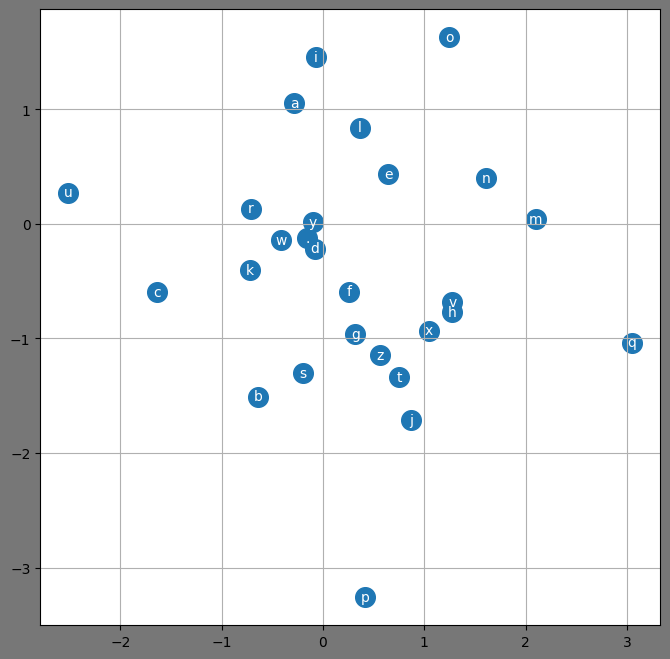

In [136]:
dim = 0
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("#777777")
sc = plt.scatter(np.C[:, dim].data, np.C[:,dim + 1].data, s=200)
for i in range(np.C.shape[0]):
    plt.text(np.C[i, dim].item(), np.C[i, dim + 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [142]:
logSection("Sampling")

samplingSeed = learningSeed + 10
gSampling = torch.Generator(device=dvc).manual_seed(samplingSeed)
log("samplingSeed", samplingSeed)

samples = sample(np, gSampling, contextSize, itos, 20)
for s in samples:
    logSimple("".join(s.values) + "  ", end="")
    for p in [s.prob] + s.probs:
        logSimple(f"{(p * 100):.0f} ", end="")
    logSimple()

Sampling:            -------------------------- 2023-07-06 16:25:46
samplingSeed:        2147483657
mora.  39288 204 191 614 640 1286 
kayah.  910359 251 1142 401 278 660 2586 
seel.  1465 174 242 52 450 751 
nihayla.  194545 92 537 97 1152 40 782 808 1109 
reisha.  387300 140 433 498 248 428 1445 583 
endra.  34127 137 122 219 553 773 1308 
gradee.  65756 51 592 1698 94 210 355 1277 
daelin.  248764 142 1175 95 470 360 504 1287 
shi.  4757 174 540 336 604 
jen.  2978 208 453 633 199 
eden.  26241 137 144 331 1030 1939 
estanar.  20651 137 158 809 199 469 408 58 427 
kayziohlaia.  287598 251 1142 401 38 518 64 97 141 587 175 208 817 
noshubergiagriel.  886380 92 384 9 85 320 60 903 290 24 364 825 22 531 328 222 1182 1587 
kindreelynn.  2983454522 251 245 889 206 189 781 283 238 634 1794 1231 2283 
novana.  3921137 92 384 567 1806 1513 326 1535 
ubelled.  1630 6 111 665 588 1794 808 6 595 
ryyah.  35588 140 198 15 2121 915 2586 
fael.  6966 37 1071 94 1328 700 
yuvan.  112831 45 396 318

In [138]:
ps = calcProb(np, "mel.", contextSize, stoi)
op = calcOneProb(ps)
for p in [op] + ps:
    logSimple(f"{(p * 100):.0f} ", end="")

4611 204 312 866 336 

In [139]:
np.C.shape, trX.shape, np.C[trX].shape, np.C[:5], trX[:5], np.C[trX][:5]

(torch.Size([27, 10]),
 torch.Size([182625, 3]),
 torch.Size([182625, 3, 10]),
 tensor([[-0.1544, -0.1219,  0.0563,  0.2539,  0.0586, -0.6481, -0.2017, -0.2347,
           0.0312,  0.2624],
         [-0.2824,  1.0536,  0.7583, -0.2038, -0.7090, -0.3084,  0.0665,  1.3576,
          -0.5027, -0.1641],
         [-0.6437, -1.5086, -0.9064, -2.7676,  0.3315,  0.1901, -0.1921, -0.1966,
          -1.8433,  1.0535],
         [-1.6330, -0.5943,  0.7731, -1.1068,  0.7744,  1.5281,  0.1892, -0.8380,
           0.4223, -0.4036],
         [-0.0786, -0.2147,  0.6969,  1.5337,  1.0417,  1.2704,  0.9003, -0.0612,
           1.1322, -0.7829]], grad_fn=<SliceBackward0>),
 tensor([[ 0,  0,  0],
         [ 0,  0, 25],
         [ 0, 25, 21],
         [25, 21,  8],
         [21,  8,  5]]),
 tensor([[[-0.1544, -0.1219,  0.0563,  0.2539,  0.0586, -0.6481, -0.2017,
           -0.2347,  0.0312,  0.2624],
          [-0.1544, -0.1219,  0.0563,  0.2539,  0.0586, -0.6481, -0.2017,
           -0.2347,  0.0312,  0.26

In [141]:
import torch
import math# this ensures that the current MacOS version is at least 12.3+
#log(torch.backends.mps.is_available())# this ensures that the current current PyTorch installation was built with MPS activated.
#log(torch.backends.mps.is_built())

In [ ]:
# Let"s suppose these are your lists
C = [
[ 0.8774, -0.6801],
         [ 0.1651, -0.5025],
         [ 0.2769, -0.3570],
         [-0.8820,  0.3902],
         [-0.4824,  0.8744],
         [-0.3190,  0.7807],
         [-0.0100, -0.3401],
         [ 0.9975,  2.8280],
         [ 0.9623, -1.3172],
         [ 0.2180, -0.3820],
         [ 0.6139, -0.4287],
         [-0.7386,  0.5880],
         [-0.3088,  0.9816],
         [ 0.3907, -0.4174],
         [-0.7380,  0.5205],
         [-0.5288,  0.7074],
         [-0.3956,  0.9625],
         [-0.3802, -0.3504],
         [-0.2861,  0.7589],
         [ 0.5309, -0.5105],
         [-0.0922, -0.6410],
         [-0.3823,  0.9899],
         [ 0.0965, -0.5708],
         [-0.8582, -1.3429],
         [-0.4960,  0.2842],
         [-0.6105,  0.1336],
         [-0.2623,  0.2942]
]
trX = [
    [0, 0, 0],
    [0, 0, 22],
    [0, 22, 9],
    [22, 9, 15],
    [9, 15, 12],
    # ... More values
]

# We create a new list to hold the result
result = []

# We loop over each element in trX
for i in range(len(trX)):
    temp = []
    # Then we loop over each value in the element
    for j in range(len(trX[i])):
        # We use the value as an index to get the corresponding data from C
        temp.append(C[trX[i][j]])
    # We add the result to our new list
    result.append(temp)

# Let"s log the first 5 elements of the result list
for i in range(5):
    print(result[i])

[[0.8774, -0.6801], [0.8774, -0.6801], [0.8774, -0.6801]]
[[0.8774, -0.6801], [0.8774, -0.6801], [0.0965, -0.5708]]
[[0.8774, -0.6801], [0.0965, -0.5708], [0.218, -0.382]]
[[0.0965, -0.5708], [0.218, -0.382], [-0.5288, 0.7074]]
[[0.218, -0.382], [-0.5288, 0.7074], [-0.3088, 0.9816]]
